In [3]:
import numpy as np
import tensorflow as tf

In [4]:
DATASET_DIR = '../Data/Stanford_Online_Products/'
FULL_DATASET_FILE = 'Ebay_info.txt'

In [10]:
class DataHandler:

    def __init__(self, dataset_dir,
                 split_dataset=0.2,
                 batch_size=16,
                 target_shape=(400, 400)):
        self.__target_shape = target_shape
        self.__dataset_dir = dataset_dir

        self.__dataset_partitions = split_dataset

        self.__train, self.__validation = self.__generate_dataset(batch_size=batch_size)

    def __generate_dataset(self, batch_size):
        data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                         width_shift_range=0.2,
                                                                         height_shift_range=0.2,
                                                                         shear_range=0.2,
                                                                         zoom_range=0.2,
                                                                         horizontal_flip=True,
                                                                         fill_mode='nearest',
                                                                         validation_split=self.__dataset_partitions)

        train = data_generator.flow_from_directory(self.__dataset_dir, class_mode="categorical",
                                                   target_size=self.__target_shape, color_mode='rgb',
                                                   batch_size=batch_size, shuffle=True, subset='training')

        validation = data_generator.flow_from_directory(self.__dataset_dir, class_mode="categorical",
                                                        target_size=self.__target_shape, color_mode='rgb',
                                                        batch_size=batch_size, subset='validation')

        return train, validation

    def get_train(self):
        return self.__train

    def get_validation(self):
        return self.__validation

    def get_shape(self):
        return self.__target_shape

In [13]:
data_handler = DataHandler(dataset_dir=DATASET_DIR, target_shape=(128, 128), batch_size=64)

train = data_handler.get_train()
validation = data_handler.get_validation()

Found 96047 images belonging to 12 classes.
Found 24006 images belonging to 12 classes.


In [5]:
type(train)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

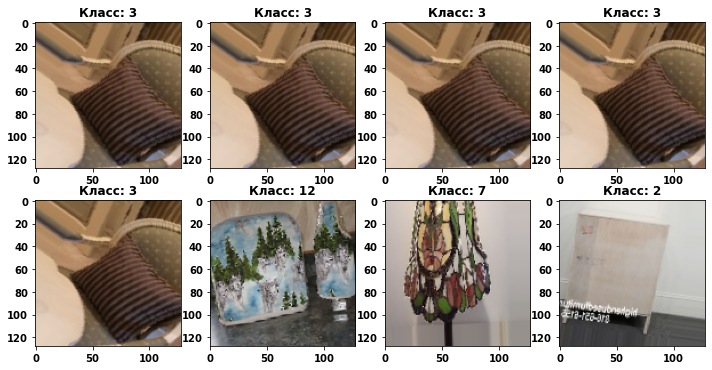

In [6]:
from matplotlib import pyplot as plt

first_batch = next(iter(train))

HEIGHT = 2
WIDTH = 4

fig, ax = plt.subplots(HEIGHT, WIDTH)
fig.set_figwidth(3 * WIDTH)
fig.set_figheight(3 * HEIGHT)
for i in range(HEIGHT):
    for j in range(WIDTH):
        ax[i, j].set_title(f'Класс: {np.argmax(first_batch[1][i * j]) + 1}')
        ax[i, j].imshow(first_batch[0][i * j].astype(int))

Функция потерь

In [11]:
class TripletHardLoss(tf.keras.losses.Loss):

    def __init__(self, margin=0.5):
        super().__init__()
        self.__margin = margin

    @tf.autograph.experimental.do_not_convert
    def call(self, y_true, y_pred):
        labels = tf.convert_to_tensor(y_true, name="labels")
        embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

        convert_to_float32 = (
                embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
        )
        precise_embeddings = (
            tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
        )

        batch_size = tf.shape(precise_embeddings)[0]
        adjacency_matrix = tf.matmul(labels, labels, transpose_b=True)
        adjacency_matrix = tf.cast(adjacency_matrix, tf.bool)
        negative_adjacency = tf.math.logical_not(adjacency_matrix)
        negative_adjacency = tf.cast(negative_adjacency, dtype=tf.dtypes.float32)
        positive_adjacency = tf.cast(adjacency_matrix, dtype=tf.dtypes.float32) - tf.eye(batch_size,
                                                                                         dtype=tf.float32)

        dist = tf.sqrt(tf.math.reduce_sum(
            tf.square(
                tf.tile(precise_embeddings, [batch_size, 1]) - tf.repeat(precise_embeddings, repeats=batch_size, axis=0)
            ), axis=1)
        )

        distance_embeddings = tf.reshape(dist, [batch_size, batch_size])

        hard_positives = self.__maximum_dist(distance_embeddings, positive_adjacency)
        hard_negatives = self.__minimum_dist(distance_embeddings, negative_adjacency)

        triplet_loss = tf.maximum(hard_positives - hard_negatives + self.__margin, 0.0)
        triplet_loss = tf.reduce_mean(triplet_loss)
        if convert_to_float32:
            return tf.cast(triplet_loss, embeddings.dtype)
        else:
            return triplet_loss

    def __minimum_dist(self, data, mask):
        axis_maximums = tf.math.reduce_max(data, 1, keepdims=True)

        masked_minimums = (
                tf.math.reduce_min(
                    tf.math.multiply(data - axis_maximums, mask), 1, keepdims=True
                )
                + axis_maximums
        )
        return masked_minimums

    def __maximum_dist(self, data, mask):

        masked_maximums = (
            tf.math.reduce_max(
                tf.math.multiply(data, mask), 1, keepdims=True
            )
        )

        return masked_maximums


In [8]:
from tensorflow.keras.applications import resnet


class EmbeddingModel(tf.keras.Model):

    def __init__(self, target_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__base_cnn = resnet.ResNet50(
            weights="imagenet", input_shape=target_shape + (3,), include_top=False
        )

        trainable = False
        for layer in self.__base_cnn.layers:
            if layer.name == "conv5_block1_out":
                trainable = True
            layer.trainable = trainable

        self.__conv_1 = tf.keras.layers.Conv2D(128, kernel_size=(7, 7), padding='same', activation='relu')
        self.__pooling_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.__conv_2 = tf.keras.layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu')
        self.__pooling_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.__flatten_1 = tf.keras.layers.Flatten()
        self.__dense_1 = tf.keras.layers.Dense(1024, activation="relu")
        self.__batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.__dense_2 = tf.keras.layers.Dense(512, activation="relu")
        self.__batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.__embedding = tf.keras.layers.Dense(256, kernel_regularizer='l2')

    @tf.autograph.experimental.do_not_convert
    def call(self, inputs, training=None, mask=None):
        layer = self.__base_cnn(inputs)
        layer = self.__conv_1(layer)
        layer = self.__pooling_1(layer)
        layer = self.__conv_2(layer)
        layer = self.__pooling_2(layer)
        layer = self.__flatten_1(layer)
        layer = self.__dense_2(layer)
        layer = self.__batch_norm_2(layer)
        layer = self.__embedding(layer)
        return layer

    def get_config(self):
        return {
            '__flatten_1': self.__flatten_1,
            '__dense_2': self.__dense_2,
            '__batch_norm_2': self.__batch_norm_2,
            '__embedding': self.__embedding,
            '__base_cnn': self.__base_cnn,
            '__dense_1': self.__dense_1,
            '__batch_norm_1': self.__batch_norm_1,
            '__conv_1': self.__conv_1,
            '__conv_2': self.__conv_2,
            '__pooling_1': self.__pooling_1,
            '__pooling_2': self.__pooling_2
        }

    def from_config(cls, config, custom_objects=None):
        return cls(**config)

In [20]:
embedding_model = EmbeddingModel(target_shape=data_handler.get_shape())
embedding_model.compile(optimizer='adam', loss=TripletHardLoss(margin=0.5))

In [21]:
embedding_model.fit(train, batch_size=64, validation_data=validation, epochs=1)

1501/1501 [==============================] - 5577s 4s/step - loss: 0.6839 - val_loss: 0.6507

In [ ]:
# Загрузка весов модели. Путь необходим указать к файлу hard_model. Пример: Model/hard_model
# embedding_model = EmbeddingModel(target_shape=(128, 128))
# embedding_model.load_weights('Some path')

In [ ]:
#Сохранение весов модели
#embedding_model.save_weights('Some path')